## Loading Dependencies

In [73]:
%pip install pandas
%pip install matplotlib
%pip install plotly


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Importing Libraries

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go


## Preprocessing
#### Loading in the Badminton Serving Data, filtering out the blank data and grouping them according to observations

In [75]:
serving_data = pd.read_csv('badmintondata.csv')

observation_num = 0
is_group = False

for index, row in serving_data.iterrows():
    if row['HUMAN PLAYER POSITION (X) metres'] == 0:
        if is_group:
            observation_num += 1
            is_group = False
        serving_data.drop(index, inplace=True)
    elif row['HUMAN PLAYER POSITION (X) metres'] == 4 and not is_group:
        is_group = True
        serving_data.at[index, 'OBSERVATION NUMBER'] = observation_num
    elif row['HUMAN PLAYER POSITION (X) metres'] == 4 and is_group:
        serving_data.at[index, 'OBSERVATION NUMBER'] = observation_num

serving_data['OBSERVATION NUMBER'] = serving_data['OBSERVATION NUMBER'].astype(int)
serving_data['SERVING SHOT'] = 1

# serving_data.head(100)

In [76]:
print(observation_num)
serving_data.head(100)
sample_serving_data = serving_data.head(1000)

364


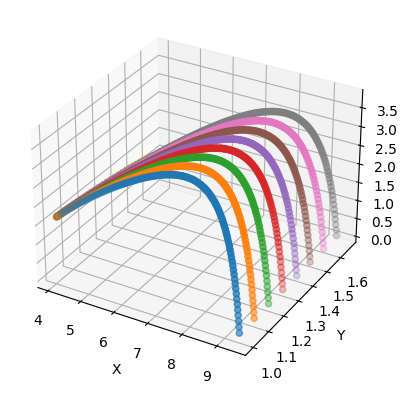

In [77]:
# sample_serving_data.head()
df_filtered = sample_serving_data.iloc[2:]
max_group_id = df_filtered['OBSERVATION NUMBER'].max()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for group_id in range(max_group_id + 1):
    group_df = df_filtered[df_filtered['OBSERVATION NUMBER'] == group_id]
    x = group_df['SHUTTLECOCK POSITIION IN AIR(X ) metres']
    y = group_df['SHUTTLECOCK POSITIION IN AIR(Y) metres']
    z = group_df['SHUTTLECOCK POSITIION IN AIR(Z) metres']
    
    ax.scatter(x, y, z)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [78]:
# Assuming you have a DataFrame named 'sample_serving_data' with columns 'OBSERVATION NUMBER',
# 'SHUTTLECOCK POSITIION IN AIR(X) metres', 'SHUTTLECOCK POSITIION IN AIR(Y) metres',
# and 'SHUTTLECOCK POSITIION IN AIR(Z) metres'

# Filter rows starting from row 2
df_filtered = sample_serving_data.iloc[2:]

# Get the maximum group_id value
max_group_id = df_filtered['OBSERVATION NUMBER'].max()

fig = go.Figure()

for group_id in range(max_group_id + 1):
    group_df = df_filtered[df_filtered['OBSERVATION NUMBER'] == group_id]
    x = group_df['SHUTTLECOCK POSITIION IN AIR(X ) metres']
    y = group_df['SHUTTLECOCK POSITIION IN AIR(Y) metres']
    z = group_df['SHUTTLECOCK POSITIION IN AIR(Z) metres']
    
    fig.add_trace(go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        name=f'Group {group_id}'
    ))

fig.update_layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z')
    ),
    title='Interactive 3D Plot'
)
fig.write_html("interactive_plot.html")

# fig.show()

#### Loading in the Badminton Rallying Data, filtering out the blank data and grouping them according to observations

In [79]:
# returning shots after the serving shot
rally_data = pd.read_csv('badmintondata2.csv')
# sample_rally_data = rally_data.head(1000)
is_group = False

for index, row in rally_data.iterrows():
    if row['HUMAN PLAYER POSITION (X) metres'] == 0:
        if is_group:
            observation_num += 1
            print(observation_num)
            is_group = False
        rally_data.drop(index, inplace=True)
    elif row['HUMAN PLAYER POSITION (X) metres'] == 4 and not is_group:
        is_group = True
        rally_data.at[index, 'OBSERVATION NUMBER'] = observation_num
    elif row['HUMAN PLAYER POSITION (X) metres'] == 4 and is_group:
        rally_data.at[index, 'OBSERVATION NUMBER'] = observation_num

# ensure observation numbers are integers
rally_data['OBSERVATION NUMBER'] = rally_data['OBSERVATION NUMBER'].astype(int)
# indicates if observation is a service shot or not
rally_data['SERVING SHOT'] = 0

rally_data.head(50)

rally_data.to_csv('output2.csv')

365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614


In [81]:
badminton_data = pd.concat([serving_data, rally_data], ignore_index=True)
badminton_data

,HUMAN PLAYER POSITION (X) metres,HUMAN PLAYER POSITION (Y) metres,INITITAL VELOCITY OF SHUTTELCOCK(m/s),INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE),SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE),SHUTTLECOCK POSITIION IN AIR(X ) metres,SHUTTLECOCK POSITIION IN AIR(Y) metres,SHUTTLECOCK POSITIION IN AIR(Z) metres,OBSERVATION NUMBER,SERVING SHOT
0,4,1,10,40,0,4.075543,1.000000,1.662912,0,1
1,4,1,10,40,0,4.152007,1.000000,1.724866,0,1
2,4,1,10,40,0,4.228906,1.000000,1.788139,0,1
3,4,1,10,40,0,4.302100,1.000000,1.845245,0,1
4,4,1,10,40,0,4.376877,1.000000,1.904128,0,1
...,...,...,...,...,...,...,...,...,...,...
168837,4,4,70,70,50,9.276323,10.288077,3.041504,1575,0
168838,4,4,70,70,50,9.326762,10.348188,2.466079,1575,0
168839,4,4,70,70,50,9.373273,10.403617,1.861569,1575,0
168840,4,4,70,70,50,9.414002,10.452156,1.230060,1575,0


#### Labelling data to indicate if its out of bounds

In [87]:
# sample_rally_data = rally_data.head(1000)

unique_observation_number = badminton_data['OBSERVATION NUMBER'].unique()
for obs_number in unique_observation_number:
    last_row = badminton_data[badminton_data['OBSERVATION NUMBER'] == obs_number].tail(1)
    # Check the conditions for 'Shuttlecock Position in Air X' and 'Shuttlecock Position in Air Y'
    if (last_row['SHUTTLECOCK POSITIION IN AIR(X ) metres'].values[0] < 0 or
        last_row['SHUTTLECOCK POSITIION IN AIR(X ) metres'].values[0] > 13.4 or
        last_row['SHUTTLECOCK POSITIION IN AIR(Y) metres'].values[0] < 0 or
        last_row['SHUTTLECOCK POSITIION IN AIR(Y) metres'].values[0] > 5.18):
        
        # Set 'OUT OF BOUNDS' column to 1 for the corresponding observation number
        badminton_data.loc[badminton_data['OBSERVATION NUMBER'] == obs_number, 'OUT OF BOUNDS'] = 1
    else:
        badminton_data.loc[badminton_data['OBSERVATION NUMBER'] == obs_number, 'OUT OF BOUNDS'] = 0
    
badminton_data.to_csv('out-of-bounds.csv')